In [2]:
import numpy as np
from numba import jit
from matplotlib.pyplot import *
%matplotlib inline

In [3]:
@jit
def bound(val,bnd):
    '''Bound val to the interval [0,bnd).'''
    if val >= bnd or val < 0:
        return val%bnd
    else:
        return val

@jit
def bound_array(arr,bnd):
    '''Bound an array of values to the interval [0,bnd) in place.'''
    assert(len(arr.shape)==1)
    for i,val in enumerate(arr):
        arr[i] = bound(val,bnd)
    
import math
@jit
def euclidean_distance(y1,x1,y2,x2):
    '''Find the Euclidean distance between two points'''
    return math.sqrt( ((x1-x2)*(x1-x2)) + ((y1-y2)*(y1-y2)) )

In [4]:
@jit
def write_radii(grid,pix,radius,val,periodicity):
    '''Assign a values to cells within the radii of another cell.'''
    n = pix.shape[1]
    assert(pix.shape[0]==2)
    Y,X = grid.shape
    
    for i in range(n):
        
        r = radius[i]
        
        miny = pix[0,i]-r
        if miny<0 and not periodicity[0]:
            miny = 0
        
        maxy = pix[0,i]+r
        if maxy>=Y and not periodicity[0]:
            maxy = Y
        
        minx = pix[1,i]-r
        if minx<0 and not periodicity[1]:
            minx = 0
        
        maxx = pix[1,i]+r
        if maxx>=X and not periodicity[1]:
            maxx = X
        
        for y in range(miny,maxy):
            if periodicity[0]:
                y = bound(y,Y)
            
            for x in range(minx,maxx):
                if periodicity[1]:
                    x = bound(x,X)
                if euclidean_distance(pix[0,i],pix[1,i],y,x)<=r:
                    grid[y,x] = val[i]

In [5]:
class Simulation:
    def __init__(self,shape,houses,defspace,Tr_spread,Tr_succession,Tr_disturbance):
        self.shape = shape
        self.k
        self.n_cells = np.prod(self.shape)
        
        self.landscape = np.zeros(shape,int)
        self.burns = np.zeros(shape,dtype=int)
        
        self.buffers = [np.zeros((bufferlength,2),dtype=int),np.zeros((bufferlength,2),dtype=int)]
        self.active_buffer = 0
        
        self.randnumbuffer = [0]
        self.is_periodic = np.array([False,False])
        
    def run(self):
        pass
    
    def burn(self):
        if self.active_buffer == 0:
            self.cursor = _burn(self.landscape,self.Tr_spread,self.buffers[0],self.cursor,
                                self.buffers[1],self.neighbors,self.is_periodic)
        elif self.active_buffer == 1:
            self.cursor = _burn(landscape,Tr_spread,buffers[0],self.cursor,buffers[1],neighbors,)
    
    def reset():
        pass

In [19]:
#@jit(nopython=True)
def _burn(landscape,burns,burnval,Tr_spread,oldfires,cursor,newfires,neighbors,is_periodic):
    #print("------------------")
    newcursor = 0
    #neigh = np.array([0,0])
    n_neighbors = neighbors.shape[0]
    Y,X = landscape.shape
    #print(Y,X)
    neighbor = np.array([0,0])
    
    # Loop through pixels already on fire
    for i_firepix in range(cursor):
        #print("i_firepix ",i_firepix)
        pix = oldfires[i_firepix]
        landtype = landscape[pix[0],pix[1]]
        
        # Loop through neighbors of that pixel
        for i_neighbor in range(n_neighbors):
            
            neighbor[0] = pix[0] + neighbors[i_neighbor,0]
            neighbor[1] = pix[1] + neighbors[i_neighbor,1]
            
            #print("neighbor",neighbor)
            
            if (neighbor[0] >= Y or neighbor[0] < 0):
                #print("y too big")
                if is_periodic[0]:
                    #print("   bounding")
                    neighbor[0] = bound(neighbor[0],Y)
                else:
                    continue
            
            if (neighbor[1] >= X or neighbor[1] < 0):
                #print("y too big")
                if is_periodic[1]:
                    neighbor[1] = bound(neighbor[1],X)
                    #print("   bounding")
                else:
                    continue
            
            # Roll the dice to see if neighbor gets burned
            if (np.random.rand() <= Tr_spread[landtype,landscape[neighbor[0],neighbor[1]]] and
                np.isnan(burns[neighbor[0],neighbor[1]])):
                
                newfires[newcursor] = neighbor
                newcursor += 1
                burns[neighbor[0],neighbor[1]] = burnval
                
    return newcursor

//anaconda/lib/python3.4/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


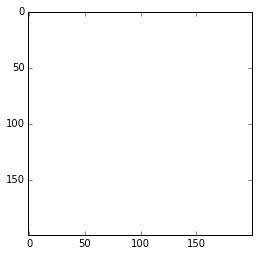

In [30]:
shp = np.array([200,200])
landscape = np.zeros(shp,dtype=int)
burns = np.zeros(shp,dtype=float)
burns[:] = np.nan

Tr_spread = np.array([[0.50,0.0],
                      [0.0,0.0]],dtype=float)

neighbors = np.array([[-1,0],[0,-1],[1,0],[0,1]])
is_periodic = np.array([False,False],dtype=bool)
newfires = np.zeros((10000,2),dtype=int)
oldfires = np.zeros((10000,2),dtype=int)
oldfires[0] = shp/2

cursor = 1
burn_iter = 1;

#fig = figure(figsize=(7,7))
while(cursor):
    cursor = _burn(landscape,burns,burn_iter,Tr_spread,oldfires,cursor,newfires,neighbors,is_periodic)
    #print("cursor",cursor)
    burn_iter+= 1
    oldfires,newfires = newfires,oldfires
    
imshow(np.ma.array(burns,mask=np.isnan(burns)))